In [4]:
# General Imports
import os
import pandas as pd
import numpy as np
from rdkit import Chem
import time
import sys
from pathlib import Path
SELFIES_coder_path = Path("../SELFIES_coder")
sys.path.append(SELFIES_coder_path.as_posix())
import SELFIES_coder as SELFIES_CODER
import selfies as sf

SELFIES_CODER.TEST()

# Inital time
start = time.time()


# Know where user actually is
directory_path = os.getcwd()
print("My current directory is : " + directory_path)
folder_name = os.path.basename(directory_path)
print("My directory name is : " + folder_name)

#load file with smiles codes to train and test (in this case one column is enough)
smifile = ('../Data/test_training_data_smiles.parquet')

data = pd.read_parquet(smifile)


from sklearn.model_selection import train_test_split
smiles_train, smiles_test = train_test_split(data["SMILES"], test_size=0.1, train_size=0.9, random_state=42)
print(smiles_train.shape)
print(smiles_test.shape)


print(data[:10])


data = SELFIES_CODER.get_encoded_SELFIES(data['SMILES'].to_list())

print(data[2])


# characters that are used in given SMILES dataset along with initial and stopping characters
charset = set("".join(list(data[0]))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
embed = data[3] + 5 #20
print(str(charset))
print(len(charset), embed)

shap = smiles_train.shape[0]
shap1 = smiles_test.shape[0]


import json
json = json.dumps(data[2])
f = open("SELFIES_to_mol_seq.json","w")
f.write(json)
f.close()

import json 
json = json.dumps(data[1])
f = open("mol_seq_to_SELFIES.json","w")
f.write(json)
f.close()

import json

json = json.dumps(char_to_int)

# open file for writing, "w" 
f = open("mol_seq_to_int.json","w")
f.write(json)
f.close()

import json
json1 = json.dumps(int_to_char)

# open file for writing, "w" 
f = open("int_to_mol_seq.json","w")
f.write(json1)
f.close()


#vectorization of molecular sequence code
def vectorize(smiles, shap):
        one_hot =  np.zeros((shap, embed , len(charset)),dtype=np.int8)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,0:-1,:], one_hot[:,1:,:]
smiles_train_ = data[0][:int(shap)]
smiles_test_ = data[0][int(shap):int(shap+shap1)]
X_train, Y_train = vectorize(smiles_train_, shap)
X_test,Y_test = vectorize(smiles_test_, shap1)
print(smiles_train.iloc[0])


#going back from vectorized form to redable string
string_test = "".join([int_to_char[idx] for idx in np.argmax(X_train[0,:,:], axis=1)])
print(string_test)

decoded = SELFIES_CODER.convert_back_to_SEFLIES(string_test, data[1])
print(decoded)

decoded_two = SELFIES_CODER.convert_back_to_SEFLIES(smiles_train_[0], data[1])
print(decoded_two)

print("Correct encoding-decoding: "+str(decoded == decoded_two))

smiles_train_[0]
#Import Keras objects
#LSTM cells special kinds of neural network units that are designed to keep an internal state for longer iterations
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Concatenate
from keras import regularizers
input_shape = X_train.shape[1:]
output_dim = Y_train.shape[-1]
latent_dim = 128
lstm_dim = 128



#encoder-decoder architecture
unroll = False
encoder_inputs = Input(shape=input_shape)
encoder = LSTM(lstm_dim, return_state=True,
                unroll=unroll)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
states = Concatenate(axis=-1)([state_h, state_c])
neck = Dense(latent_dim, activation="relu")
neck_outputs = neck(states)



decode_h = Dense(lstm_dim, activation="relu")
decode_c = Dense(lstm_dim, activation="relu")
state_h_decoded =  decode_h(neck_outputs)
state_c_decoded =  decode_c(neck_outputs)
encoder_states = [state_h_decoded, state_c_decoded]
decoder_inputs = Input(shape=input_shape)
decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll
                   )
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(output_dim, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
#Define the model, that inputs the training vector for two places, and predicts one character ahead of the input
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
print(model.summary())


from keras.callbacks import History, ReduceLROnPlateau
h = History()
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=15, min_lr=0.000001, verbose=1, min_delta=1e-5) #epsilon=min_delta



from tensorflow.keras.optimizers import RMSprop, Adam
opt=Adam(learning_rate=0.005) #Default 0.001
model.compile(optimizer=opt, loss='categorical_crossentropy')



start_MODEL = time.time()
model.fit([X_train,X_train],Y_train, epochs=200, batch_size=256, shuffle=True, callbacks=[h, rlr], validation_data=([X_test,X_test],Y_test)) #100
end_MODEL = time.time()
print("The time of execution of above program is :", end_MODEL-start_MODEL)


import pickle
f = open("Neural_network_history.pickle","wb")
pickle.dump(h.history, f)


smiles_to_latent_model = Model(encoder_inputs, neck_outputs)

smiles_to_latent_model.save("mol_seq2lat.h5")


latent_input = Input(shape=(latent_dim,))
#reuse_layers
state_h_decoded_2 =  decode_h(latent_input)
state_c_decoded_2 =  decode_c(latent_input)
latent_to_states_model = Model(latent_input, [state_h_decoded_2, state_c_decoded_2])
latent_to_states_model.save("lat2state.h5")


#Last one is special, we need to change it to stateful, and change the input shape
inf_decoder_inputs = Input(batch_shape=(1, 1, input_shape[1]))
inf_decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll,
                    stateful=True
                   )
inf_decoder_outputs = inf_decoder_lstm(inf_decoder_inputs)
inf_decoder_dense = Dense(output_dim, activation='softmax')
inf_decoder_outputs = inf_decoder_dense(inf_decoder_outputs)
sample_model = Model(inf_decoder_inputs, inf_decoder_outputs)


#Transfer Weights
for i in range(1,3):
    sample_model.layers[i].set_weights(model.layers[i+6].get_weights())
sample_model.save("samplemodel.h5")



print(sample_model.summary())


end = time.time()


print("The time of execution of above program is :", end-start)

working
My current directory is : C:\Users\aleks\Indole\prediction_and_selection
My directory name is : prediction_and_selection
(120935,)
(13438,)
                                              SMILES
0  N1=NN(C=C1COCC2=C[NH1]C3=CC=CC=C32)CCCCCCCCCCC...
1  [NH1]1C=C(COCC=2N=NN(C=2)CCCCCCCCCCCCN3C=C(N=N...
2  C12=C(C(COCC3=CN(N=N3)CC=4C5=C(C=CC=C5)N(C=4)C...
3  C1=CC=2[NH1]C=C(COCC3=CN(CCCCCN4N=NC(COCC=5C6=...
4  C1=CC=C2C(CN3C(=CC(=O)N(C3=O)CC4=C[NH1]C5=CC=C...
5  C1(=O)CC(=O)N(CC=2C3=CC=CC=C3[NH1]C=2)C(N1CC4=...
6  C(C1=CN(N=N1)CCCCCCCCN2N=NC(COCC3=C[NH1]C4=CC=...
7  C1=C(COCC=2C3=C(C=CC=C3)[NH1]C=2)N=NN1CC=4C5=C...
8  C(OCC1=C[NH1]C2=CC=CC=C21)C=3N=NN(C=3)CCCCCCCC...
9      C1=CC=C2C([NH1]C=C2CC3=C[NH1]C4=CC=CC=C34)=C1
All works correct, encoding leads to the same data during decoding...
{'[S]': '#', '[Cl]': '$', '[=Ring2]': '%', '[=Branch1]': '&', '[=N]': "'", '[=O]': '(', '[NH1]': ')', '[N+1]': '*', '[Branch2]': '+', '[=Branch2]': ',', '[#C]': '-', '[Branch1]': '.', '[#Branch2]': '

473/473 [==============================] - 7s 14ms/step - loss: 0.0106 - val_loss: 0.0056
Epoch 115/200
473/473 [==============================] - 7s 14ms/step - loss: 0.0026 - val_loss: 0.0050
Epoch 116/200
473/473 [==============================] - 7s 14ms/step - loss: 0.0055 - val_loss: 0.0170
Epoch 117/200
473/473 [==============================] - 7s 14ms/step - loss: 0.0077 - val_loss: 0.0051
Epoch 118/200
473/473 [==============================] - 7s 14ms/step - loss: 0.0057 - val_loss: 0.0088
Epoch 119/200
473/473 [==============================] - 7s 14ms/step - loss: 0.0118 - val_loss: 0.0051
Epoch 120/200
473/473 [==============================] - 7s 14ms/step - loss: 0.0024 - val_loss: 0.0038
Epoch 121/200
473/473 [==============================] - 7s 14ms/step - loss: 0.0033 - val_loss: 0.0081
Epoch 122/200
473/473 [==============================] - 7s 14ms/step - loss: 0.0087 - val_loss: 0.0071
Epoch 123/200
473/473 [==============================] - 7s 14ms/step - loss: 

In [ ]:
import pickle #if the history file is empty
f = open("Neural_network_history.pickle","wb")
pickle.dump(h.history, f)

4.7635287046432495e-05
0.0009029218344949186


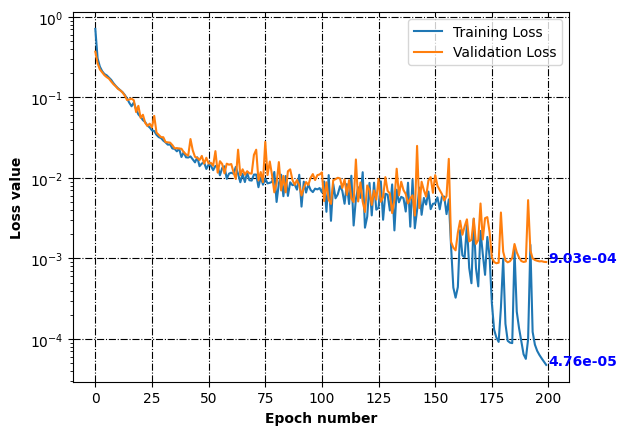

In [2]:
import pandas as pd
import numpy as np

history__ = pd.read_pickle('Neural_network_history.pickle')
print(history__["loss"][-1])
print(history__["val_loss"][-1])


from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(history__["loss"], label="Training Loss")
plt.plot(history__["val_loss"], label="Validation Loss")
plt.yscale("log", base=10)
plt.rc('grid', linestyle="-.", color='black')
plt.grid(True)
plt.text(200, history__["loss"][-1],'4.76e-05', horizontalalignment='left', fontweight='bold', color='blue')
plt.text(200, history__["val_loss"][-1],'9.03e-04', horizontalalignment='left', fontweight='bold', color='blue')
plt.legend()
plt.xlabel("Epoch number", fontweight='bold')
plt.ylabel("Loss value", fontweight='bold')
plt.savefig('model_loss_plot.pdf', bbox_inches='tight')  
plt.show()